1. In the previous notebook I cleaned and preprocessed the data so that its in good shape to be inputted for model building in scikit learn. However, I will take a step back here and explore the original raw train data because it's easier to visualize the categorical variables before they are transformed. 

2. I will conduct all exploratory analyses on the training data only. 

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [47]:
df = pd.read_csv('./datasets/train.csv')

Let's visually inspect the relationships between features

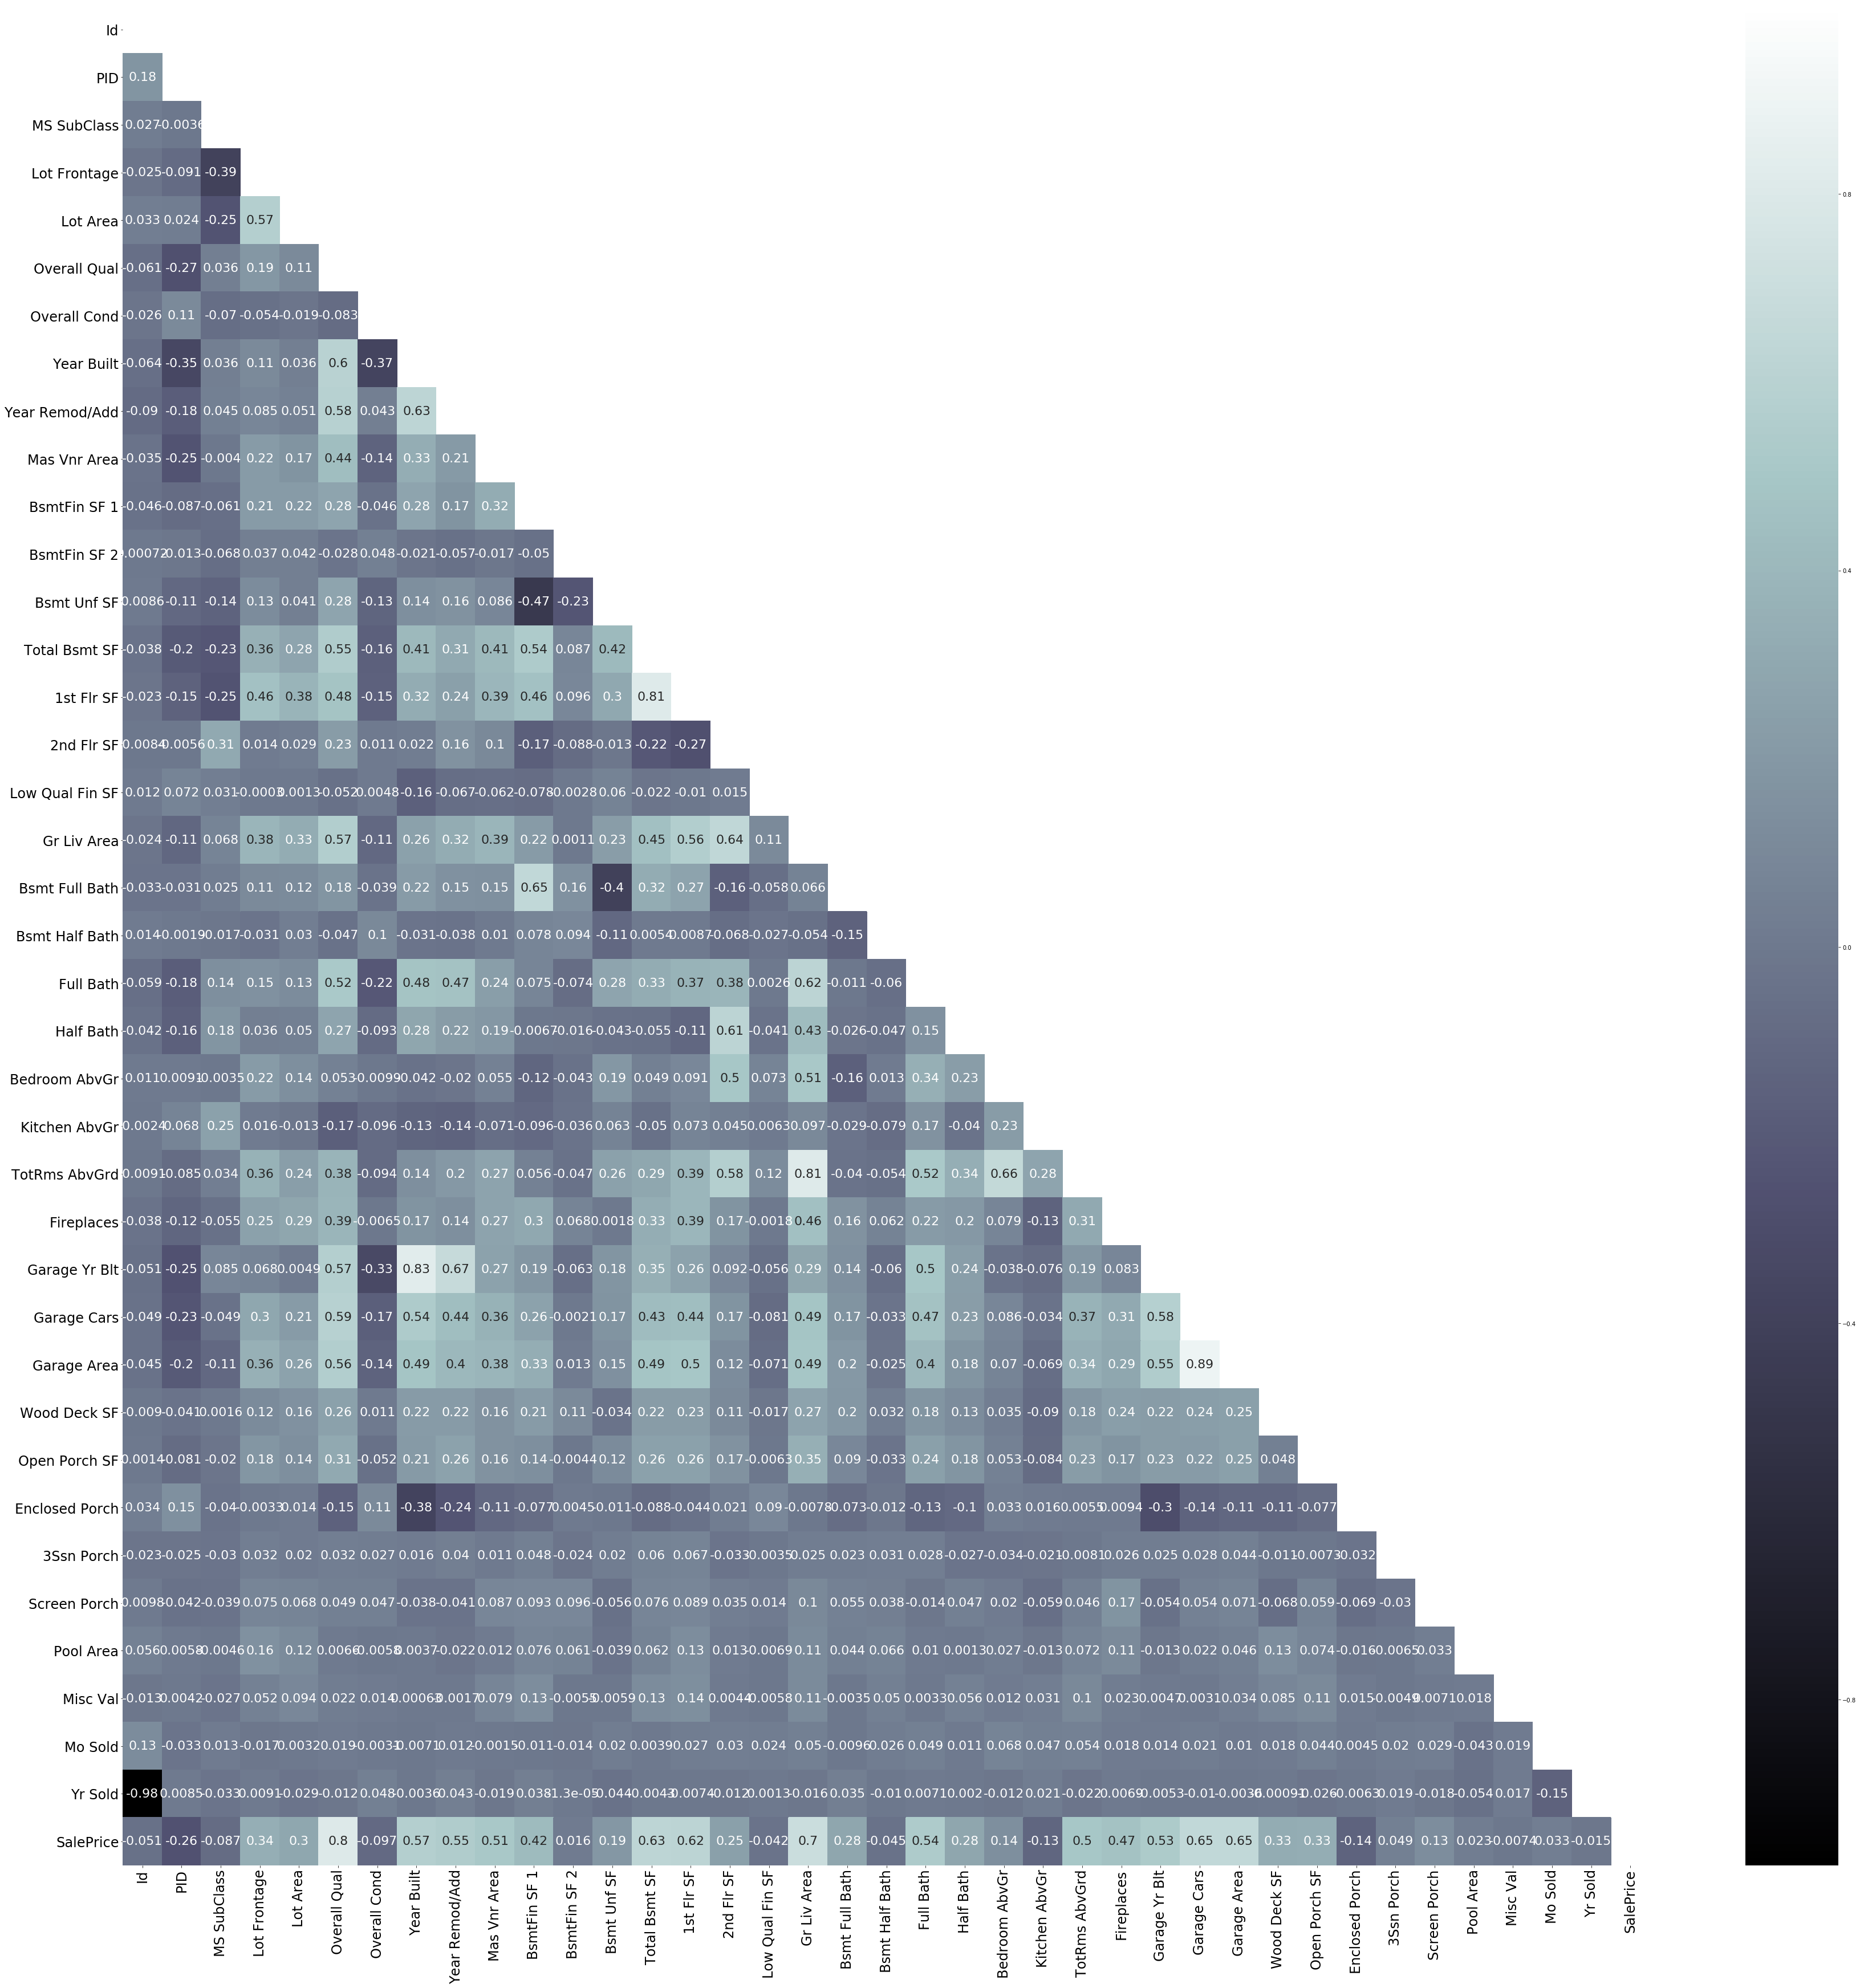

In [48]:
plt.figure(figsize=(60,60))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df.corr(), cmap ='bone', mask=mask, annot = True, annot_kws={"size": 22}) 
ax.tick_params(axis='y', labelsize=24, labelrotation=0)
ax.tick_params(axis='x', labelsize=24, labelrotation=90)

Of interest to me are features that have a correlation coefficient of above 0.5 with the Sale Price. There are also quite a few predictor features that exhibit a strong correlation with other predictor features. While this implies that our data exhibits multicollinearity, I'm not going to be too worried about this because when using Ridge or Lasso regularization to penalize or completeley get rid of irrelevant features in the modeling phase, the problem of multicollinearity should have no significant impact. 

Let's take a look at the relationship of features only with the target feature. 

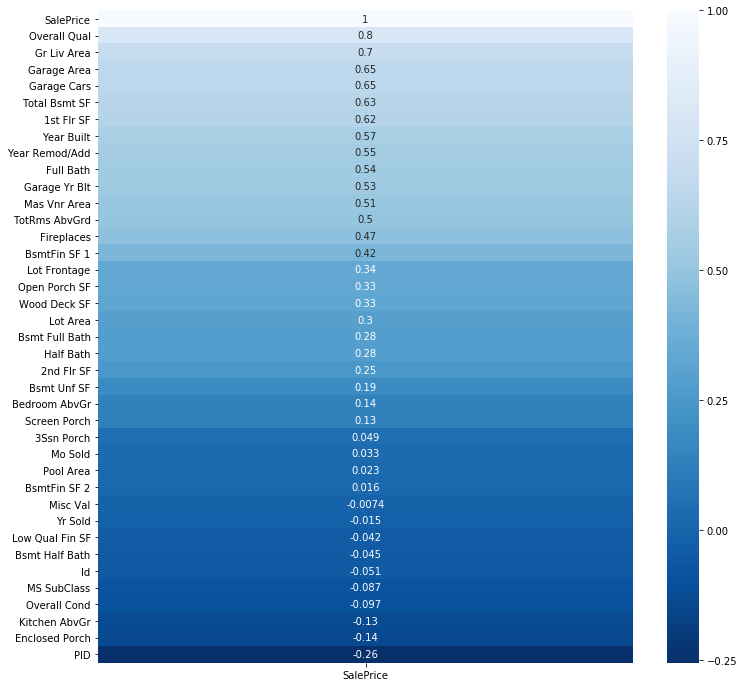

In [49]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False), annot=True, cmap='Blues_r')

### A Little Bit of Feature Engineering 

**Total Square Footage**: I suspect the price of a house will depend greatly on the total square footage of the house. The data does not contain this feature but I will engineer it with the help of [research](http://jse.amstat.org/v19n3/decock.pdf) into how the total square footage of the house is calcualted.

In [50]:
# create a new variable of total square footage of the house 
df['sf'] = df['1st Flr SF'] + df['2nd Flr SF'] + df['BsmtFin SF 1'] + df['BsmtFin SF 2']

**Outside**: Using common sense I suspect creating an interaction term between Wood Deck SF and Open Porch SF may result in a relatively strong correlation with my target, even though on their own these featrues do not seem to be highly correlated with target. I thought this might make sense because if a house has an open porch AND a wooden deck, that may indicate that there is large enough ckyard/frontyard area and good enough outdoor condition for the house so that its outdoor area can be used for recreational/relaxation purposes. I believe this interaction may be a better predictor for house price than each of those features individually. 

In [51]:
df['outside']= df['Open Porch SF']*df['Wood Deck SF']

**Year**: Another interaction term I thought may be useful is the interaction between the year in which the house was built AND the year in which it was remodeled (if remodeled at all)

In [52]:
df['year'] = df['Year Built']*df['Year Remod/Add']

**Garage**: Lastly I'm curious to investigate the interaction between garage square footage and the capacity of the garage to hold n-number of cars. Some people turn and remodel their garages into storage space or a workshop. I wonder if having a garage that preserves its original function may be useful for the price of a house on sale. 

In [53]:
df['garage'] = df['Garage Area'] * df['Garage Cars']

Having added these engineered features, let's visualize the features' correlation with the target variable again and see whether these interaction terms have a higher correlation with the target as opposed to the correlation between individual features in the interaction and the target. 

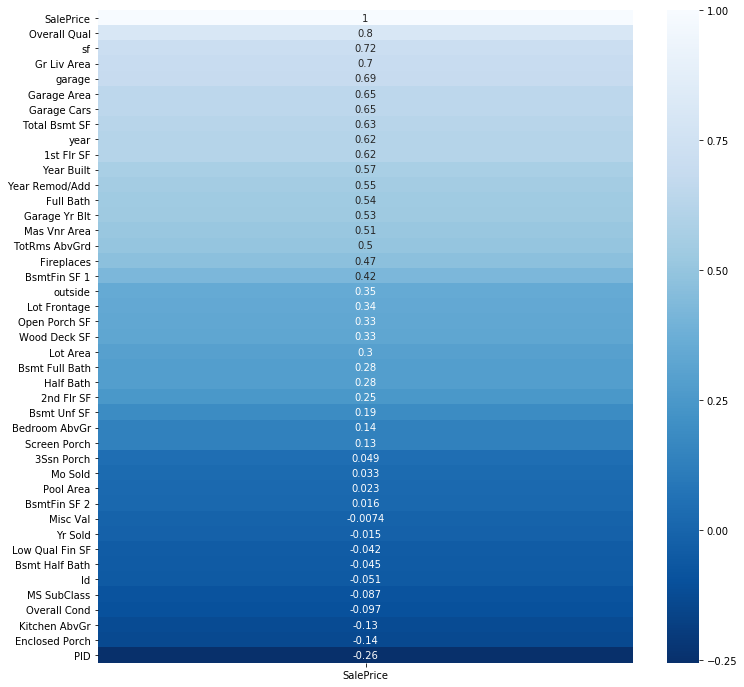

In [54]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False), annot=True, cmap='Blues_r')

It looks like the ineraction terms do indeed exhibit stronger correlation with target than does each feature individually, so I'll keep them. 

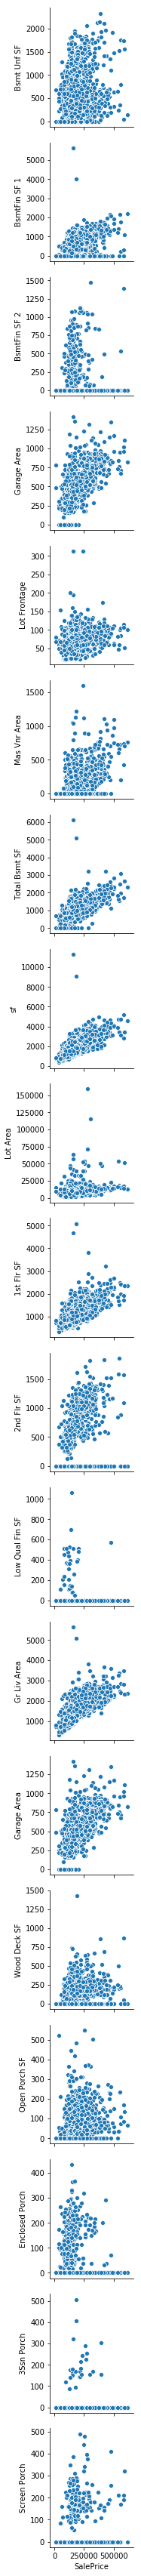

In [55]:
# scatterplot of all numeric columns against the target 
numeric_cols = ['Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Garage Area', 'Lot Frontage', 'Mas Vnr Area', 'Total Bsmt SF', 'sf', 'Lot Area', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch']
numeric_cols
sns.pairplot(df, y_vars=numeric_cols, x_vars=['SalePrice'])

None of the features against the target echibit any obvious or concerning non-linearity such as curvy scatter of the data. 

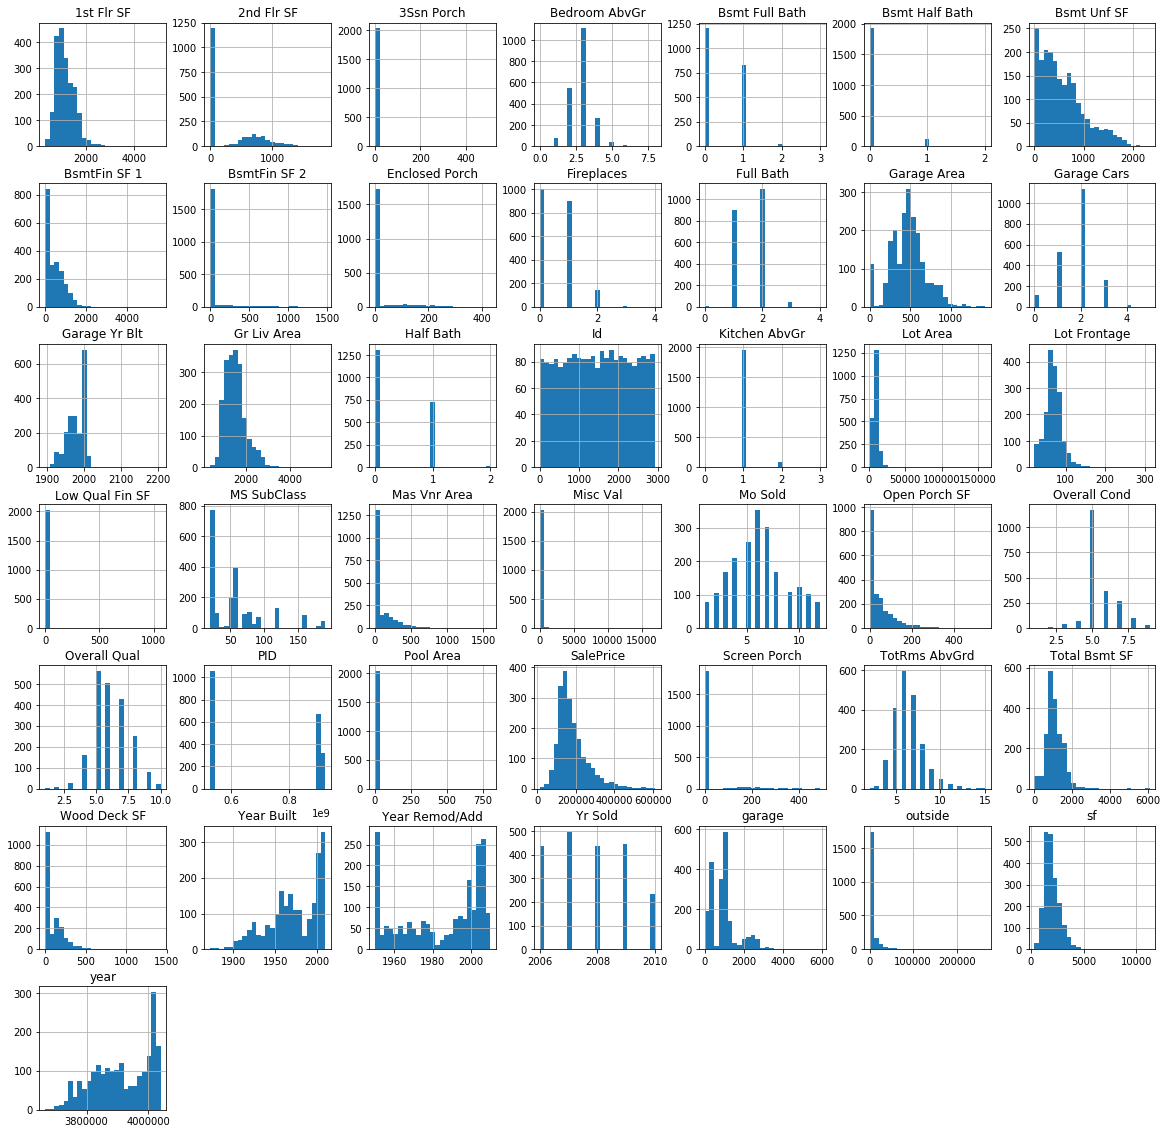

In [56]:
# distributions of features 
df.hist(figsize = (20,20), bins = 25);

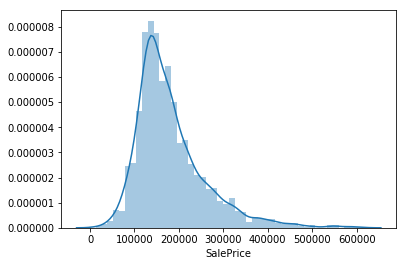

In [57]:
# distribution of the target feature 
sns.distplot(df['SalePrice'], kde = True)

Some of the features, including the target feature exhibit some skew in their distribution. This is ok because I will later be using power transforms in my pipeline to normalize all the features. Also by looking at the scales of the different features in the scatterplots and the histograms, it's apparent that the features have very different scales so a standard scaler transform will also need to be applied.